<a href="https://colab.research.google.com/github/MS-H2020/Open/blob/main/Brain_Tumor_Detection_YOLOv8_CV_SAM_coronal_t1wce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Brain tumor object detection datasets](https://www.kaggle.com/davidbroberts/brain-tumor-object-detection-datasets)

## Refference

- [Brain Tumor Detection using YOLO v10](https://www.kaggle.com/code/metinmekiabullrahman/brain-tumor-detection-using-yolo-v10)
- [Brain_Tumor_Detection (SAM)](https://www.kaggle.com/code/giovanniimbesi/brain-tumor-detection)
- [K-Fold Cross Validation with Ultralytics](https://docs.ultralytics.com/guides/kfold-cross-validation/)
- [Train YOLOv5 + Cross Validation + Ensemble + W&B](https://www.kaggle.com/code/ayuraj/train-yolov5-cross-validation-ensemble-w-b)
- [ Is model ensembling available for Yolov8? #3665 ](https://github.com/ultralytics/ultralytics/issues/3665)
- [ Model ensembling with yolov8 #3036 ](https://github.com/ultralytics/ultralytics/issues/3036)
- [ YOLOV8 Model Ensembling #6113 ](https://github.com/ultralytics/ultralytics/issues/6113)

## Setting for Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## YOLO v8 with K-Fold

### Training

In [ ]:
!pip install ultralytics
!pip install pyyaml
!pip install wandb
import ultralytics
from ultralytics import YOLO
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import wandb
wandb.init(mode="disabled")
import shutil

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.8/872.8 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 104.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.7 MB/s eta 0:00:00


In [ ]:
#shutil.unpack_archive('/content/drive/MyDrive/Brain_Tumor/axial_t1wce_2_class.zip', './')
shutil.unpack_archive('/content/drive/MyDrive/Brain_Tumor/coronal_t1wce_2_class.zip', './')
#shutil.unpack_archive('/content/drive/MyDrive/Brain_Tumor/sagittal_t1wce_2_class.zip', './')

In [ ]:
files = os.listdir('./coronal_t1wce_2_class/images/train')
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]
print(random_file)

62 (10)


In [ ]:
with open(os.path.join('./coronal_t1wce_2_class/labels/train', f'{random_file}.txt'),'r') as f:
    labels = f.readlines()
    labels = labels[0].split(' ')
    f.close()

(512, 512, 3)


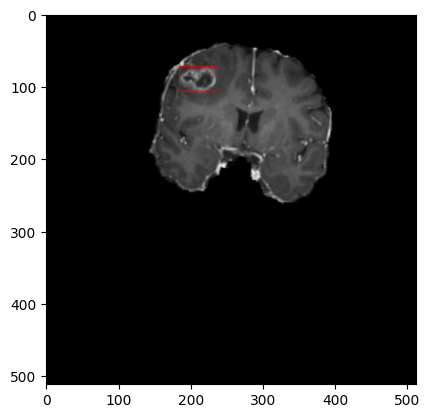

In [ ]:
img = cv2.imread(os.path.join('./coronal_t1wce_2_class/images/train', f'{random_file}.jpg'), 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
x_pt1 = int((x - w/2) * img.shape[1])
y_pt1 = int((y - h/2) * img.shape[0])
x_pt2 = int((x + w/2) * img.shape[1])
y_pt2 = int((y + h/2) * img.shape[0])

if tumor_class == 1:
    colour = (255, 0, 0)
else:
    colour = (0, 255, 0)
cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)

print(img.shape)
plt.imshow(img)

In [ ]:
train_images = os.listdir('./coronal_t1wce_2_class/images/train')
test_images = os.listdir('./coronal_t1wce_2_class/images/test')
train_labels = os.listdir('./coronal_t1wce_2_class/labels/train')
test_labels = os.listdir('./coronal_t1wce_2_class/labels/test')

num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

print(num_train_images, num_test_images)
print(num_train_labels, num_test_labels)

319 78
318 78


In [ ]:
os.path.splitext(random_file)[0]
unlabelled = set(train_images) - set([os.path.splitext(file)[0] + '.jpg' for file in train_labels])

for image in unlabelled:
    os.remove(os.path.join('./coronal_t1wce_2_class/images/train', image))

In [ ]:
train_images = os.listdir('./coronal_t1wce_2_class/images/train')
test_images = os.listdir('./coronal_t1wce_2_class/images/test')
train_labels = os.listdir('./coronal_t1wce_2_class/labels/train')
test_labels = os.listdir('./coronal_t1wce_2_class/images/test')

num_train_images = len(train_images)
num_test_images = len(test_images)
num_train_labels = len(train_labels)
num_test_labels = len(test_labels)

print(num_train_images, num_test_images)
print(num_train_labels, num_test_labels)

318 78
318 78


In [ ]:
val_split = int(num_train_images * 0.2)
val_images = random.sample(train_images, val_split)

if os.path.exists('./coronal_t1wce_2_class/images/val'):
    shutil.rmtree('./coronal_t1wce_2_class/images/val')
if os.path.exists('./coronal_t1wce_2_class/labels/val'):
    shutil.rmtree('./coronal_t1wce_2_class/labels/val')

os.mkdir('./coronal_t1wce_2_class/images/val')
os.mkdir('./coronal_t1wce_2_class/labels/val')

for image in val_images:
    shutil.move(os.path.join('./coronal_t1wce_2_class/images/train', image), './coronal_t1wce_2_class/images/val')

for image in val_images:
    label = os.path.splitext(image)[0] + '.txt'
    shutil.move(os.path.join('./coronal_t1wce_2_class/labels/train', label), './coronal_t1wce_2_class/labels/val')

In [ ]:
from pathlib import Path

dataset_path = Path("./coronal_t1wce_2_class")  # replace with 'path/to/dataset' for your custom data
labels = sorted(dataset_path.rglob("*.txt"))  # all data in 'labels'

In [ ]:
print(labels)

[PosixPath('coronal_t1wce_2_class/labels/test/13.txt'), PosixPath('coronal_t1wce_2_class/labels/test/15.txt'), PosixPath('coronal_t1wce_2_class/labels/test/17.txt'), PosixPath('coronal_t1wce_2_class/labels/test/19.txt'), PosixPath('coronal_t1wce_2_class/labels/test/20.txt'), PosixPath('coronal_t1wce_2_class/labels/test/23.txt'), PosixPath('coronal_t1wce_2_class/labels/test/33.txt'), PosixPath('coronal_t1wce_2_class/labels/test/34.txt'), PosixPath('coronal_t1wce_2_class/labels/test/35.txt'), PosixPath('coronal_t1wce_2_class/labels/test/36.txt'), PosixPath('coronal_t1wce_2_class/labels/test/38.txt'), PosixPath('coronal_t1wce_2_class/labels/test/40.txt'), PosixPath('coronal_t1wce_2_class/labels/test/41.txt'), PosixPath('coronal_t1wce_2_class/labels/test/42.txt'), PosixPath('coronal_t1wce_2_class/labels/test/44.txt'), PosixPath('coronal_t1wce_2_class/labels/test/45.txt'), PosixPath('coronal_t1wce_2_class/labels/test/46 (2).txt'), PosixPath('coronal_t1wce_2_class/labels/test/46 (3).txt'), P

In [ ]:
text ="""
path: ../coronal_t1wce_2_class
train: images/train
val: images/val

# Classes
nc: 2
names: ['negative','positive']
"""

with open('./fixed_path.yaml', 'w') as file:
    file.write(text)

In [ ]:
import yaml
yaml_file = "./fixed_path.yaml"  # your data YAML with data directories and names dictionary
with open(yaml_file, "r", encoding="utf8") as y:
    classes = yaml.safe_load(y)["names"]
cls_idx = sorted(classes)

In [ ]:
import pathlib
import pandas as pd

indx = [pathlib.Path(label).stem for label in labels]  # uses base filename as ID (no extension)
labels_df = pd.DataFrame([], columns=cls_idx, index=indx)

In [ ]:
from collections import Counter

for label in labels:
    lbl_counter = Counter()

    with open(label, "r") as lf:
        lines = lf.readlines()

    for line in lines:
        # classes for YOLO label uses integer at first position of each line
        lbl_counter[int(line.split(" ")[0])] += 1

    labels_df.loc[label.stem] = lbl_counter

labels_df = labels_df.fillna(0.0)  # replace `nan` values with `0.0`

In [ ]:
labels_df

,negative,positive
13,0.0,0.0
15,0.0,0.0
17,0.0,0.0
19,0.0,0.0
20,0.0,0.0
...,...,...
95,0.0,0.0
96 (3),0.0,0.0
96 (4),0.0,0.0
96,0.0,0.0


In [ ]:
from sklearn.model_selection import KFold

ksplit = 5
kf = KFold(n_splits=ksplit, shuffle=True, random_state=20)  # setting random_state for repeatable results

kfolds = list(kf.split(labels_df))

In [ ]:
folds = [f"split_{n}" for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=indx, columns=folds)

for idx, (train, val) in enumerate(kfolds, start=1):
    folds_df[f"split_{idx}"].loc[labels_df.iloc[train].index] = "train"
    folds_df[f"split_{idx}"].loc[labels_df.iloc[val].index] = "val"

In [ ]:
fold_lbl_distrb = pd.DataFrame(index=folds, columns=cls_idx)

for n, (train_indices, val_indices) in enumerate(kfolds, start=1):
    train_totals = labels_df.iloc[train_indices].sum()
    val_totals = labels_df.iloc[val_indices].sum()

    # To avoid division by zero, we add a small value (1E-7) to the denominator
    ratio = val_totals / (train_totals + 1e-7)
    fold_lbl_distrb.loc[f"split_{n}"] = ratio

In [ ]:
import datetime

supported_extensions = ".jpg"

# Initialize an empty list to store image file paths
images = []

# Loop through supported extensions and gather image files
for ext in supported_extensions:
  images.extend(sorted((dataset_path / "images").rglob(f"*{ext}")))

# Create the necessary directories and dataset YAML files (unchanged)
save_path = Path(dataset_path / f"{datetime.date.today().isoformat()}_{ksplit}-Fold_Cross-val")
save_path.mkdir(parents=True, exist_ok=True)
ds_yamls = []

for split in folds_df.columns:
    # Create directories
    split_dir = save_path / split
    split_dir.mkdir(parents=True, exist_ok=True)
    (split_dir / "train" / "images").mkdir(parents=True, exist_ok=True)
    (split_dir / "train" / "labels").mkdir(parents=True, exist_ok=True)
    (split_dir / "val" / "images").mkdir(parents=True, exist_ok=True)
    (split_dir / "val" / "labels").mkdir(parents=True, exist_ok=True)

    # Create dataset YAML files
    dataset_yaml = split_dir / f"{split}_dataset.yaml"
    ds_yamls.append(dataset_yaml)

    with open(dataset_yaml, "w") as ds_y:
        yaml.safe_dump(
            {
                "path": '../' + split_dir.as_posix(),
                "train": "train",
                "val": "val",
                "names": classes,
            },
            ds_y,
        )

In [ ]:
import shutil

for image, label in zip(images, labels):
    for split, k_split in folds_df.loc[image.stem].items():
        # Destination directory
        img_to_path = save_path / split / k_split / "images"
        lbl_to_path = save_path / split / k_split / "labels"

        # Copy image and label files to new directory (SamefileError if file already exists)
        shutil.copy(image, img_to_path / image.name)
        shutil.copy(label, lbl_to_path / label.name)

In [ ]:
from ultralytics import YOLO

weights_path = "./yolov8n.pt"
model = YOLO(weights_path, task="detect")

100%|██████████| 6.25M/6.25M [00:00<00:00, 334MB/s]


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!wandb login --relogin 4703b281064fe4613044a2eda64e69d557e28906

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import gc
results = {}

# Define your additional arguments here
project = "brain_tumor_coronal"
epochs = 50

for k in range(ksplit):
    dataset_yaml = ds_yamls[k]
    model.train(data=dataset_yaml, epochs=epochs, batch=-1, project=project, device=0)  # include any train arguments
    results[k] = model.metrics  # save output metrics for further analysis
    gc.collect()

Ultralytics YOLOv8.2.95 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=./yolov8n.pt, data=coronal_t1wce_2_class/2024-09-18_5-Fold_Cross-val/split_1/split_1_dataset.yaml, epochs=50, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=brain_tumor_coronal, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_co

100%|██████████| 755k/755k [00:00<00:00, 115MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/coronal_t1wce_2_class/2024-09-18_5-Fold_Cross-val/split_1/train/labels... 316 images, 0 backgrounds, 0 corrupt: 100%|██████████| 316/316 [00:00<00:00, 1841.62it/s]

train: New cache created: /content/coronal_t1wce_2_class/2024-09-18_5-Fold_Cross-val/split_1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/coronal_t1wce_2_class/2024-09-18_5-Fold_Cross-val/split_1/val/labels... 80 images, 0 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:00<00:00, 642.90it/s]

val: New cache created: /content/coronal_t1wce_2_class/2024-09-18_5-Fold_Cross-val/split_1/val/labels.cache


Plotting labels to brain_tumor_coronal/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005625000000000001), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to brain_tumor_coronal/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      9.44G       1.81      4.963      1.521         43        640: 100%|██████████| 5/5 [00:06<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.92s/it]

                   all         80         84   0.000502      0.186   0.000325   0.000162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      9.07G      1.729      4.878      1.451         46        640: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]

                   all         80         84    0.00143       0.43    0.00104   0.000541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      9.03G      1.561      4.349      1.286         52        640: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all         80         84    0.00251      0.701     0.0201    0.00331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      9.09G      1.359      3.393      1.112         49        640: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

                   all         80         84    0.00112      0.314       0.16     0.0829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      9.03G      1.185      2.774      1.061         37        640: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

                   all         80         84    0.00183      0.484      0.198      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      9.03G       1.14      2.511      1.065         41        640: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]

                   all         80         84    0.00152      0.423     0.0454     0.0318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      9.03G      1.099      2.319      1.052         42        640: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all         80         84    0.00199      0.578     0.0278     0.0213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      9.03G      1.116      2.324      1.064         47        640: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]

                   all         80         84    0.00221      0.643      0.122     0.0759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      9.03G      1.015       2.08      1.005         50        640: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

                   all         80         84    0.00232      0.666     0.0511     0.0222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      9.03G     0.9956      1.952      1.009         49        640: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.93s/it]

                   all         80         84      0.002      0.555      0.155     0.0938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      9.09G      1.018      1.952      1.009         43        640: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

                   all         80         84    0.00305      0.875      0.498      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      9.09G      1.062       1.93      1.023         44        640: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

                   all         80         84     0.0027      0.782      0.304      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      9.03G      1.048      1.822      1.026         43        640: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

                   all         80         84    0.00245      0.723      0.214      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      9.03G      1.033      1.715      1.017         50        640: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

                   all         80         84      0.612      0.055      0.431      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      9.09G      1.109      1.834      1.054         35        640: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

                   all         80         84      0.436      0.115      0.242      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      9.03G       1.03      1.761      1.027         53        640: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

                   all         80         84      0.854      0.106      0.604      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      9.03G     0.9894       1.58      1.009         41        640: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

                   all         80         84       0.78      0.265      0.544      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      9.03G      1.047      1.603      1.035         29        640: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         80         84      0.708      0.163      0.304      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      9.03G      1.014      1.494      1.009         50        640: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

                   all         80         84      0.538      0.207      0.355      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      9.03G      1.018      1.506      1.037         39        640: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all         80         84      0.345      0.131      0.209      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      9.03G      1.006      1.396      1.008         40        640: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

                   all         80         84      0.268      0.381      0.242      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      9.03G      1.033      1.452       1.05         32        640: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

                   all         80         84      0.445      0.519      0.403      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      9.03G      1.005      1.353     0.9895         36        640: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

                   all         80         84      0.626      0.577      0.591      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      9.03G     0.8978      1.274     0.9722         40        640: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.34s/it]

                   all         80         84      0.658      0.557      0.627      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      9.09G      0.976      1.235      0.999         29        640: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all         80         84      0.627      0.642      0.679      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      9.03G     0.9542      1.183          1         35        640: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         80         84      0.616       0.71      0.705       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      9.03G     0.8804      1.092     0.9663         57        640: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all         80         84      0.591      0.654      0.601      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      9.03G     0.9637      1.117      1.007         42        640: 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         80         84      0.578      0.684      0.635      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       9.1G     0.9258      1.091     0.9652         43        640: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         80         84      0.718      0.629      0.704      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      9.03G     0.8834     0.9946     0.9541         46        640: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

                   all         80         84      0.523       0.56      0.517      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      9.03G     0.8943      1.032     0.9852         33        640: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all         80         84      0.768      0.661      0.764      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      9.09G     0.9226      1.013     0.9965         47        640: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         80         84      0.685      0.676      0.711      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       9.1G     0.8951     0.9828     0.9624         37        640: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all         80         84      0.652       0.81      0.787      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      9.03G     0.8561     0.9127     0.9781         52        640: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

                   all         80         84      0.762      0.674      0.771      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      9.08G     0.8322     0.8363     0.9585         54        640: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

                   all         80         84      0.598      0.727      0.731      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      9.08G     0.8255     0.8615     0.9604         45        640: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all         80         84      0.808      0.729      0.828      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      9.03G     0.8571     0.8465     0.9613         39        640: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all         80         84      0.775       0.72      0.824      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      9.03G     0.8526      0.858     0.9619         40        640: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all         80         84      0.847      0.657       0.79      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      9.03G     0.8557     0.8133     0.9651         33        640: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         80         84       0.72      0.843       0.84      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      9.08G     0.8064     0.7712     0.9585         43        640: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

                   all         80         84      0.799      0.795       0.86      0.656


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      9.03G     0.7251     0.7312     0.9076         29        640: 100%|██████████| 5/5 [00:10<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         80         84       0.77      0.802       0.82      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      9.03G     0.7368     0.7139     0.9143         28        640: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

                   all         80         84      0.895       0.76      0.866      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      9.03G     0.7104     0.6585     0.9012         32        640: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all         80         84      0.691      0.891       0.85       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      9.03G     0.7031     0.6474      0.896         30        640: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         80         84      0.807       0.87      0.878      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      9.03G     0.6909     0.6312      0.897         30        640: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all         80         84      0.841      0.743      0.871      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      9.03G     0.6843     0.6065     0.8996         29        640: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all         80         84      0.668      0.915      0.861      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      9.03G      0.699     0.5873     0.9024         28        640: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

                   all         80         84      0.713      0.948      0.899      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      9.03G     0.6526     0.5694     0.8746         30        640: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         80         84      0.865       0.84        0.9      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      9.03G     0.6376     0.5702     0.8703         32        640: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all         80         84      0.768      0.882        0.9      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      9.03G     0.6402     0.5497     0.8787         30        640: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         80         84      0.781      0.883      0.898      0.688



50 epochs completed in 0.104 hours.
Optimizer stripped from brain_tumor_coronal/train/weights/last.pt, 6.3MB
Optimizer stripped from brain_tumor_coronal/train/weights/best.pt, 6.3MB

Validating brain_tumor_coronal/train/weights/best.pt...
Ultralytics YOLOv8.2.95 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


                   all         80         84      0.866       0.84      0.901      0.695
              negative         48         51      0.916      0.863      0.915       0.72
              positive         32         33      0.817      0.818      0.888       0.67
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to brain_tumor_coronal/train
Ultralytics YOLOv8.2.95 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=./yolov8n.pt, data=coronal_t1wce_2_class/2024-09-18_5-Fold_Cross-val/split_2/split_2_dataset.yaml, epochs=50, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=brain_tumor_coronal, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=Non

wandb: Currently logged in as: pch-neurodive-osa036 (pch-neurodive-osa036-japan). Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.75G total, 0.29G reserved, 0.11G allocated, 14.35G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     3011238       8.195         0.375         19.37         13.19        (1, 3, 640, 640)                    list
     3011238       16.39         0.298          22.9         18.03        (2, 3, 640, 640)                    list
     3011238       32.78         0.528          21.9         20.25        (4, 3, 640, 640)                    list
     3011238       65.56         1.034          29.4         31.08        (8, 3, 640, 640)                    list
     3011238       131.1         1.902         38.91         45.86       (16, 3, 640, 640)                    list
Aut

train: Scanning /content/coronal_t1wce_2_class/2024-09-18_5-Fold_Cross-val/split_2/train/labels... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<00:00, 2221.82it/s]

train: New cache created: /content/coronal_t1wce_2_class/2024-09-18_5-Fold_Cross-val/split_2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/coronal_t1wce_2_class/2024-09-18_5-Fold_Cross-val/split_2/val/labels... 79 images, 0 backgrounds, 0 corrupt: 100%|██████████| 79/79 [00:00<00:00, 956.17it/s]

val: New cache created: /content/coronal_t1wce_2_class/2024-09-18_5-Fold_Cross-val/split_2/val/labels.cache


Plotting labels to brain_tumor_coronal/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006015625), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to brain_tumor_coronal/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      9.66G     0.6456     0.6476     0.9051          9        640: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         79         82      0.965      0.984      0.985      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      9.62G      0.648     0.6078     0.8911         11        640: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all         79         82      0.941       0.92      0.978      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      9.62G     0.7161     0.7023     0.9152          9        640: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

                   all         79         82      0.939      0.916      0.971      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      9.62G     0.6999     0.7335     0.8951          8        640: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         79         82      0.962      0.934      0.962      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      9.62G     0.7457     0.6779     0.9021         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all         79         82       0.91      0.899      0.966      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      9.62G     0.6855     0.6703     0.9003          9        640: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

                   all         79         82      0.928      0.878       0.96      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      9.62G     0.7189     0.6906     0.9152         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         79         82      0.956      0.937      0.962      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      9.62G      0.702     0.6513     0.9185          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all         79         82      0.895      0.868      0.912      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      9.62G     0.7333     0.6588     0.9187         10        640: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         79         82      0.861      0.883      0.919      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      9.62G     0.6955     0.6756     0.8986         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         79         82      0.902      0.881      0.944      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      9.62G     0.7581     0.6489     0.9107         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all         79         82      0.723       0.86      0.869      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      9.62G     0.7419     0.6934      0.922         10        640: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all         79         82      0.674      0.723      0.703      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      9.62G     0.7324     0.7054     0.9085          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

                   all         79         82      0.822      0.856      0.921      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      9.62G     0.7243     0.6502     0.8997          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         79         82      0.619      0.784      0.731      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      9.62G     0.7642     0.7685     0.9312         11        640: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

                   all         79         82       0.68      0.654      0.761       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      9.62G     0.7116     0.7174     0.9155          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

                   all         79         82      0.651       0.67      0.688      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      9.62G     0.8302     0.6959     0.9528         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

                   all         79         82      0.821      0.636      0.788      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      9.62G     0.7222      0.678     0.9037         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

                   all         79         82      0.767      0.776      0.851       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      9.62G      0.755     0.6847     0.9387         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all         79         82      0.777      0.747      0.793       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      9.62G     0.7745     0.7012     0.9433         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         79         82      0.525      0.774      0.675      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      9.62G     0.7857     0.7203     0.9383          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

                   all         79         82      0.656      0.761      0.747      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      9.62G     0.7688     0.6841     0.9126         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         79         82      0.788      0.746      0.809      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      9.62G     0.7846     0.7475     0.9251          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all         79         82      0.658      0.807      0.749      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      9.62G     0.7659     0.6879     0.9474         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]

                   all         79         82      0.856      0.793      0.859       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      9.62G     0.7401     0.5984     0.9388         10        640: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all         79         82      0.767      0.729      0.804      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      9.62G      0.745     0.6235     0.9127         11        640: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         79         82      0.813      0.782      0.819      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      9.62G     0.7263     0.6136     0.9293          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

                   all         79         82      0.679      0.759       0.75      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      9.62G     0.7418     0.5709     0.9182          9        640: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

                   all         79         82       0.88      0.841      0.909      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      9.62G     0.7791     0.6221     0.9038          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

                   all         79         82      0.866      0.833       0.88      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      9.62G     0.7249     0.5816     0.9024         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]

                   all         79         82      0.763      0.892       0.88       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      9.62G     0.6979     0.5946     0.8801          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all         79         82      0.753      0.784      0.772       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      9.62G     0.7163     0.5642     0.9117          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all         79         82      0.732       0.89      0.857      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      9.62G     0.6621     0.5346     0.9014          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

                   all         79         82      0.736      0.774       0.75      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      9.62G     0.6791     0.5194     0.8688          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all         79         82      0.833      0.805      0.866      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      9.62G     0.7461     0.5411     0.9429         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         79         82       0.79      0.766      0.858      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      9.62G     0.6572     0.4866     0.8863          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]

                   all         79         82      0.832      0.874      0.907      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      9.62G     0.6551     0.4629     0.8948          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all         79         82      0.888      0.825      0.896      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      9.62G     0.6651     0.4696     0.8922          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         79         82      0.891      0.848      0.906      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      9.62G     0.6353      0.443     0.8718          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         79         82      0.887      0.854      0.911      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      9.62G     0.6277     0.4414     0.8543         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

                   all         79         82      0.888      0.888      0.932      0.692


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      9.62G     0.6534     0.5007     0.8615          9        640: 100%|██████████| 5/5 [00:09<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

                   all         79         82      0.887      0.859      0.909       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      9.62G     0.6086     0.3979     0.8585          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all         79         82      0.823      0.871      0.917        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      9.62G     0.6008     0.4251     0.8841          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

                   all         79         82      0.886       0.87       0.93      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      9.62G     0.5973     0.4364     0.8625          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

                   all         79         82       0.88      0.881      0.922      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      9.62G     0.5666     0.4322     0.8445         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all         79         82        0.9      0.884       0.91       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      9.62G     0.5849     0.3869     0.8412         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]

                   all         79         82      0.924       0.87      0.917      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      9.62G     0.5454     0.3605     0.8399          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

                   all         79         82      0.849      0.907      0.917      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      9.62G     0.5485     0.3769     0.8481          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all         79         82      0.863      0.901       0.92      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      9.62G     0.5588     0.3842     0.8504          9        640: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         79         82       0.91      0.884      0.927      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      9.62G     0.5292      0.359      0.826         10        640: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

                   all         79         82      0.907      0.906      0.927      0.722



50 epochs completed in 0.104 hours.
Optimizer stripped from brain_tumor_coronal/train2/weights/last.pt, 6.3MB
Optimizer stripped from brain_tumor_coronal/train2/weights/best.pt, 6.3MB

Validating brain_tumor_coronal/train2/weights/best.pt...
Ultralytics YOLOv8.2.95 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


                   all         79         82      0.965      0.984      0.985      0.832
              negative         44         46      0.958      0.999      0.993      0.849
              positive         35         36      0.972      0.968      0.976      0.816
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to brain_tumor_coronal/train2


lr/pg0,▁▂▂▃▄▄▅▅▆▆▇▇▇██████▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
lr/pg1,▁▂▂▃▄▄▅▅▆▆▇▇▇██████▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
lr/pg2,▁▂▂▃▄▄▅▅▆▆▇▇▇██████▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
metrics/mAP50(B),███▇▇▇▆▆▅▁▇▂▁▃▅▃▂▄▂▅▄▂▆▆▃▅▂▅▆▆▆▆▆▆▇▇▆▆▆█
metrics/mAP50-95(B),███▇▇▇▅▆▅▁▅▂▁▃▃▃▁▂▂▄▃▂▄▄▂▄▂▄▅▅▅▅▅▅▅▅▅▅▅█
metrics/precision(B),██▇█▇█▇▆▃▂▅▁▂▅▄▄▂▄▂▆▅▂▆▆▄▃▃▅▅▆▇▆▆▅▆▆▇▆▆█
metrics/recall(B),█▇▇▇▆▇▆▆▆▃▅▄▂▁▄▃▄▃▄▄▄▃▅▅▄▆▄▄▆▅▅▅▅▆▆▆▆▆▆█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,▄▄▅▅▅▅▅▆▆▆▆▆▅█▅▆▇▇▇▇▆▆▆▇▅▅▄▄▄▄▄▃▄▃▃▃▂▁▁▁


Ultralytics YOLOv8.2.95 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=./yolov8n.pt, data=coronal_t1wce_2_class/2024-09-18_5-Fold_Cross-val/split_3/split_3_dataset.yaml, epochs=50, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=brain_tumor_coronal, name=train22, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.75G total, 0.17G reserved, 0.11G allocated, 14.47G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     3011238       8.195         0.247         18.91         14.43        (1, 3, 640, 640)                    list
     3011238       16.39         0.300         22.11         16.36        (2, 3, 640, 640)                    list
     3011238       32.78         0.554         20.13            20        (4, 3, 640, 640)                    list
     3011238       65.56         1.044         26.99         28.95        (8, 3, 640, 640)                    list
     3011238       131.1         2.024         38.99         46.09       (16, 3, 640, 640)                    list
Aut

train: Scanning /content/coronal_t1wce_2_class/2024-09-18_5-Fold_Cross-val/split_3/train/labels... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<00:00, 397.51it/s]

train: New cache created: /content/coronal_t1wce_2_class/2024-09-18_5-Fold_Cross-val/split_3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/coronal_t1wce_2_class/2024-09-18_5-Fold_Cross-val/split_3/val/labels... 79 images, 0 backgrounds, 0 corrupt: 100%|██████████| 79/79 [00:00<00:00, 534.54it/s]

val: New cache created: /content/coronal_t1wce_2_class/2024-09-18_5-Fold_Cross-val/split_3/val/labels.cache


Plotting labels to brain_tumor_coronal/train22/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005546875000000001), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to brain_tumor_coronal/train22
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      9.18G     0.7056     0.6766     0.8957         33        640: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all         79         84      0.974      0.998      0.994      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      8.82G     0.7356     0.7007      0.932         33        640: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         79         84      0.969      0.989      0.995      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      8.82G     0.7116     0.6553     0.9106         34        640: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

                   all         79         84      0.965       0.97       0.98      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      8.82G     0.7348     0.6427     0.9146         37        640: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all         79         84      0.951      0.948      0.991      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      8.82G     0.7332      0.652     0.9177         34        640: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]

                   all         79         84      0.942      0.932      0.983      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      8.82G     0.7508     0.6825     0.9173         33        640: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all         79         84      0.921      0.992      0.986      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      8.82G     0.7406      0.689     0.9203         33        640: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

                   all         79         84       0.96      0.962      0.983      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      8.82G     0.7184     0.6683     0.9143         35        640: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

                   all         79         84      0.867      0.926      0.949      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      8.82G     0.7097     0.7124     0.9053         35        640: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         79         84      0.854      0.917      0.919      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      8.82G      0.755     0.7129     0.9204         35        640: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

                   all         79         84      0.884       0.93      0.971      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      8.82G     0.7571     0.7198     0.9177         34        640: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

                   all         79         84      0.828      0.848      0.931      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      8.82G     0.7496     0.6693     0.9135         34        640: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all         79         84      0.931      0.903       0.97      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      8.82G     0.7813     0.6801     0.9414         34        640: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all         79         84      0.837      0.906      0.944      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      8.82G      0.752     0.6528     0.9081         35        640: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

                   all         79         84       0.91      0.894      0.966      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      8.82G     0.8261     0.7197      0.954         35        640: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all         79         84      0.657      0.865      0.819      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      8.82G     0.7938     0.6916      0.938         36        640: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         79         84       0.88      0.955       0.95      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      8.82G     0.8073     0.6976     0.9265         36        640: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all         79         84      0.765      0.838      0.856       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      8.82G     0.7936     0.6966     0.9225         35        640: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.07s/it]

                   all         79         84      0.828       0.73      0.808      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      8.82G     0.7718      0.684     0.9242         35        640: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

                   all         79         84      0.577      0.715      0.621       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      8.82G     0.7851     0.6765     0.9125         36        640: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

                   all         79         84      0.845       0.89      0.872      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      8.82G     0.8045     0.7802     0.9367         33        640: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all         79         84      0.721      0.746      0.872       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      8.82G     0.7768     0.7064     0.9335         33        640: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         79         84      0.768      0.704       0.86      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      8.82G     0.7839     0.7134     0.9309         36        640: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

                   all         79         84      0.776      0.762      0.882      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      8.82G     0.8005     0.6945     0.9511         34        640: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all         79         84       0.85       0.81      0.898      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      8.82G     0.7513     0.6149     0.9238         36        640: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         79         84      0.654      0.785      0.761      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      8.82G      0.759     0.6511     0.9123         34        640: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

                   all         79         84      0.923       0.85      0.948      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      8.82G       0.76     0.6155     0.9287         35        640: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

                   all         79         84      0.795      0.767      0.886      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      8.82G     0.7078     0.5937     0.8894         35        640: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

                   all         79         84      0.637      0.662      0.667      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      8.82G     0.7238     0.5643     0.9032         35        640: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

                   all         79         84      0.611      0.652       0.65        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      8.82G      0.755     0.5957     0.9108         33        640: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]

                   all         79         84      0.613      0.714      0.712      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      8.82G     0.7428      0.536     0.8922         35        640: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all         79         84      0.907      0.877      0.936      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      8.82G     0.6943     0.5381     0.8888         36        640: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]

                   all         79         84      0.812      0.891      0.917      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      8.82G     0.6996     0.5419      0.897         34        640: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all         79         84      0.794       0.89      0.906      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      8.82G     0.6823     0.4904      0.892         33        640: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all         79         84      0.899      0.887      0.953      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      8.82G     0.6783     0.5004     0.9032         36        640: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         79         84      0.959      0.875      0.965      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      8.82G     0.6621     0.4624     0.8827         34        640: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         79         84      0.971      0.912      0.976      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      8.82G     0.6412     0.4578     0.8784         35        640: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

                   all         79         84      0.841      0.883      0.939      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      8.82G     0.6678     0.4474     0.8799         34        640: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]

                   all         79         84        0.9      0.961      0.976      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      8.82G     0.6505     0.4487     0.8739         38        640: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         79         84      0.901      0.947      0.978      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      8.82G     0.6425      0.429     0.8842         34        640: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

                   all         79         84      0.948      0.911      0.979      0.782


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      8.82G     0.6342     0.4286     0.8695         33        640: 100%|██████████| 5/5 [00:10<00:00,  2.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]

                   all         79         84      0.895      0.923      0.974      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      8.82G     0.6324     0.4239     0.8622         35        640: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all         79         84      0.899      0.941      0.973      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      8.82G     0.6209     0.4185     0.8548         33        640: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all         79         84      0.899      0.925      0.969       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      8.82G     0.5906     0.3966     0.8603         35        640: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all         79         84      0.881      0.914      0.966       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      8.82G     0.5765     0.3993     0.8521         33        640: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all         79         84      0.922      0.866      0.946       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      8.82G     0.5848     0.3919     0.8577         35        640: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all         79         84      0.911       0.89      0.957      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      8.82G     0.5794     0.3759     0.8594         34        640: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         79         84      0.936      0.915      0.962      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      8.82G     0.5626     0.3695     0.8574         35        640: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         79         84      0.866      0.933      0.952      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      8.82G     0.5522     0.3658     0.8539         38        640: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

                   all         79         84      0.863      0.931      0.953      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      8.82G     0.5393     0.3503     0.8536         33        640: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

                   all         79         84      0.939      0.875      0.958      0.778



50 epochs completed in 0.109 hours.
Optimizer stripped from brain_tumor_coronal/train22/weights/last.pt, 6.3MB
Optimizer stripped from brain_tumor_coronal/train22/weights/best.pt, 6.3MB

Validating brain_tumor_coronal/train22/weights/best.pt...
Ultralytics YOLOv8.2.95 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


                   all         79         84      0.974      0.998      0.994      0.868
              negative         34         37      0.969          1      0.994      0.863
              positive         45         47      0.979      0.996      0.995      0.874
Speed: 0.3ms preprocess, 2.3ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to brain_tumor_coronal/train22


lr/pg0,▁▂▂▃▄▄▅▅▆▆▇▇▇██████▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
lr/pg1,▁▂▂▃▄▄▅▅▆▆▇▇▇██████▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
lr/pg2,▁▂▂▃▄▄▅▅▆▆▇▇▇██████▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
metrics/mAP50(B),██████▇▇▇█▇▇▇▅▅▁▆▅▆▆▇▆▂▂▇▇▆▇█▇█████▇▇▇▇█
metrics/mAP50-95(B),██▇█▇▇▇▆▆▆▆▆▆▄▃▁▄▄▅▅▅▅▂▂▆▆▆▆▇▆▇▇▇▇▆▆▆▆▆█
metrics/precision(B),████▇█▆▆▅▇▆▇▆▄▅▁▄▄▅▆▇▅▂▂▇▅▅▇█▆▇▇▇▇▇▆▇▇▆█
metrics/recall(B),██▇▇█▇▇▆▅▆▆▆▇▅▃▂▃▂▃▄▅▃▁▁▆▆▆▆▆▆▇▇▆▇▇▆▆▆▇█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,▅▆▆▆▇▆▆▅▇▆▇▇███▇█▇▇█▇▇▅▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁


Ultralytics YOLOv8.2.95 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=./yolov8n.pt, data=coronal_t1wce_2_class/2024-09-18_5-Fold_Cross-val/split_4/split_4_dataset.yaml, epochs=50, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=brain_tumor_coronal, name=train222, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.75G total, 0.61G reserved, 0.11G allocated, 14.02G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     3011238       8.195         0.728         25.05         18.49        (1, 3, 640, 640)                    list
     3011238       16.39         0.304         24.71         18.19        (2, 3, 640, 640)                    list
     3011238       32.78         0.535         20.51         20.59        (4, 3, 640, 640)                    list
     3011238       65.56         1.040         27.28         29.97        (8, 3, 640, 640)                    list
     3011238       131.1         1.908          39.7         46.67       (16, 3, 640, 640)                    list
Aut

train: Scanning /content/coronal_t1wce_2_class/2024-09-18_5-Fold_Cross-val/split_4/train/labels... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<00:00, 1241.44it/s]

train: New cache created: /content/coronal_t1wce_2_class/2024-09-18_5-Fold_Cross-val/split_4/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/coronal_t1wce_2_class/2024-09-18_5-Fold_Cross-val/split_4/val/labels... 79 images, 0 backgrounds, 0 corrupt: 100%|██████████| 79/79 [00:00<00:00, 623.01it/s]

val: New cache created: /content/coronal_t1wce_2_class/2024-09-18_5-Fold_Cross-val/split_4/val/labels.cache


Plotting labels to brain_tumor_coronal/train222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00065625), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to brain_tumor_coronal/train222
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      10.9G     0.7464     0.6599     0.9227         66        640: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

                   all         79         86      0.986      0.993      0.995       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      10.8G     0.7156     0.6682     0.9132         68        640: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

                   all         79         86      0.959      0.967      0.992      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      10.8G     0.7335     0.6557     0.9118         70        640: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

                   all         79         86      0.953      0.983      0.991      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      10.8G     0.7116     0.6488     0.9031         70        640: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

                   all         79         86      0.906      0.976      0.986      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      10.8G     0.7231      0.635     0.9059         66        640: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]

                   all         79         86      0.956      0.991      0.994      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      10.8G     0.7026     0.6296      0.895         65        640: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all         79         86      0.915      0.952      0.984      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      10.8G     0.6878     0.6352     0.8995         68        640: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

                   all         79         86      0.829      0.953      0.974      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      10.8G     0.6913     0.6569     0.9009         71        640: 100%|██████████| 4/4 [00:02<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all         79         86      0.899      0.923      0.986      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      10.8G     0.6953     0.6151     0.8924         69        640: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         79         86      0.893      0.919       0.97      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      10.8G     0.7136     0.6103     0.9005         67        640: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

                   all         79         86      0.927       0.87      0.948      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      10.8G     0.6951     0.6269     0.8946         67        640: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

                   all         79         86      0.941      0.869      0.949      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      10.8G     0.7035     0.5944     0.8933         66        640: 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

                   all         79         86      0.919      0.888       0.96      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      10.8G      0.703     0.6259     0.9044         68        640: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

                   all         79         86      0.911      0.889      0.943      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      10.8G     0.7264     0.6274     0.9095         68        640: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

                   all         79         86      0.874      0.936      0.954      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      10.8G     0.7468      0.649     0.9207         66        640: 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

                   all         79         86      0.894      0.913      0.954      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      10.8G     0.6933     0.5981     0.8874         69        640: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

                   all         79         86      0.812      0.838      0.879      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      10.8G     0.7393      0.591     0.9049         67        640: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]

                   all         79         86       0.83      0.856      0.908      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      10.8G     0.7602     0.6505     0.9087         68        640: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         79         86       0.76       0.93      0.915      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      10.8G     0.7507     0.5936     0.9234         70        640: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

                   all         79         86      0.817      0.877       0.89      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      10.8G      0.739     0.6001     0.9114         70        640: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all         79         86      0.862      0.846      0.894       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      10.8G     0.7236     0.6036      0.918         68        640: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all         79         86      0.828      0.814      0.904      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      10.8G     0.7079     0.6382     0.8987         70        640: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         79         86      0.814      0.848      0.911      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      10.8G      0.701      0.615     0.9029         66        640: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

                   all         79         86      0.857      0.826      0.926      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      10.8G     0.6997     0.6255     0.8992         67        640: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

                   all         79         86      0.675      0.795      0.868      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      10.8G     0.7091     0.5896     0.9029         68        640: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

                   all         79         86      0.759      0.772      0.794      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      10.8G     0.7246     0.5448      0.904         67        640: 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]

                   all         79         86      0.793      0.757      0.842      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      10.8G     0.7136     0.5473     0.9006         72        640: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

                   all         79         86      0.773      0.697      0.769      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      10.8G     0.6988     0.6024     0.8751         68        640: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all         79         86      0.702      0.627      0.613      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      10.8G     0.7029     0.5742     0.8894         68        640: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

                   all         79         86      0.845      0.796       0.86      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      10.8G     0.6836     0.5313     0.8887         66        640: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

                   all         79         86      0.831      0.746       0.83      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      10.8G     0.6716     0.5323     0.8981         69        640: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all         79         86      0.755      0.785      0.814      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      10.8G     0.6766     0.5551     0.8684         69        640: 100%|██████████| 4/4 [00:05<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all         79         86      0.774      0.727      0.831      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      10.8G     0.6623     0.5152     0.8955         68        640: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

                   all         79         86      0.724      0.862      0.858      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      10.8G     0.6385     0.4948     0.8715         66        640: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

                   all         79         86      0.766       0.83      0.883      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      10.8G     0.6475     0.4926     0.8777         67        640: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         79         86      0.756      0.831      0.882      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      10.8G     0.6472     0.4541     0.8837         68        640: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         79         86      0.773      0.812      0.849      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      10.8G     0.6361     0.4495     0.8678         73        640: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

                   all         79         86      0.756      0.766      0.821      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      10.8G     0.6189      0.457     0.8611         69        640: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all         79         86      0.829      0.806      0.911      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      10.8G     0.6102     0.4466     0.8669         69        640: 100%|██████████| 4/4 [00:04<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

                   all         79         86      0.932      0.831      0.954      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      10.8G     0.6194     0.4506     0.8623         69        640: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         79         86      0.815      0.952      0.932      0.761


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      10.8G     0.6032     0.4441     0.8585         66        640: 100%|██████████| 4/4 [00:13<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.16s/it]

                   all         79         86      0.916      0.851      0.941      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      10.8G     0.5655      0.404     0.8473         65        640: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

                   all         79         86      0.875      0.917      0.943      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      10.8G     0.5593      0.394     0.8501         68        640: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all         79         86      0.861      0.952      0.948      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      10.8G     0.5617     0.3978     0.8517         69        640: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all         79         86      0.855      0.901       0.94      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      10.8G     0.5595     0.3782     0.8456         67        640: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         79         86      0.855      0.905       0.93      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      10.8G     0.5547     0.3781     0.8478         71        640: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         79         86      0.882      0.917      0.935      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      10.8G     0.5368     0.3819     0.8567         68        640: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all         79         86      0.875      0.922      0.934      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      10.8G     0.5155     0.3643     0.8348         68        640: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]

                   all         79         86       0.88      0.924      0.935      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      10.8G     0.5229     0.3681     0.8479         67        640: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         79         86      0.877      0.941      0.937      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      10.8G     0.5088     0.3488     0.8358         67        640: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

                   all         79         86      0.873      0.941      0.938      0.779



50 epochs completed in 0.111 hours.
Optimizer stripped from brain_tumor_coronal/train222/weights/last.pt, 6.3MB
Optimizer stripped from brain_tumor_coronal/train222/weights/best.pt, 6.3MB

Validating brain_tumor_coronal/train222/weights/best.pt...
Ultralytics YOLOv8.2.95 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


                   all         79         86      0.986      0.993      0.995       0.87
              negative         42         45          1      0.986      0.995      0.901
              positive         37         41      0.971          1      0.994      0.839
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to brain_tumor_coronal/train222


lr/pg0,▁▂▂▃▄▄▄▅▆▆▆▆▇▇▇███████▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁
lr/pg1,▁▂▂▃▄▄▄▅▆▆▆▆▇▇▇███████▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁
lr/pg2,▁▂▂▃▄▄▄▅▆▆▆▆▇▇▇███████▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁
metrics/mAP50(B),████████▇▇▇▇▆▆▇▆▆▆▇▆▅▄▁▆▅▅▅▆▅▅▆▇▇▇▇▇▇▇▇█
metrics/mAP50-95(B),█████▇▇▇▆▇▆▆▅▅▆▅▅▅▆▅▄▃▁▅▃▄▅▅▄▄▅▆▆▆▆▆▆▆▆█
metrics/precision(B),█▇▇▆▆▄▆▆▇▆▆▅▄▄▃▄▄▄▅▁▄▃▂▅▃▃▂▃▃▃▄▇▆▆▅▅▆▆▆█
metrics/recall(B),████▇▇▇▇▆▆▆▇▅▅▇▆▅▅▅▄▃▂▁▄▄▃▅▅▅▄▄▅▅▇▇▆▇▇▇█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▇▇▇▆▆▆▆▆▆▆▇▆▇██▇▇▆▆▇▇▆▆▆▆▅▅▅▅▄▄▄▃▂▂▂▂▁▁


Ultralytics YOLOv8.2.95 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=./yolov8n.pt, data=coronal_t1wce_2_class/2024-09-18_5-Fold_Cross-val/split_5/split_5_dataset.yaml, epochs=50, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=brain_tumor_coronal, name=train2222, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, sav

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.75G total, 0.89G reserved, 0.11G allocated, 13.75G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     3011238       8.195         1.028         21.33          14.2        (1, 3, 640, 640)                    list
     3011238       16.39         0.304          56.8         34.39        (2, 3, 640, 640)                    list
     3011238       32.78         0.556         34.81         25.74        (4, 3, 640, 640)                    list
     3011238       65.56         1.046         31.26         36.78        (8, 3, 640, 640)                    list
     3011238       131.1         2.026         39.19         46.75       (16, 3, 640, 640)                    list
Aut

train: Scanning /content/coronal_t1wce_2_class/2024-09-18_5-Fold_Cross-val/split_5/train/labels... 317 images, 0 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<00:00, 876.63it/s]

train: New cache created: /content/coronal_t1wce_2_class/2024-09-18_5-Fold_Cross-val/split_5/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/coronal_t1wce_2_class/2024-09-18_5-Fold_Cross-val/split_5/val/labels... 79 images, 0 backgrounds, 0 corrupt: 100%|██████████| 79/79 [00:00<00:00, 687.54it/s]

val: New cache created: /content/coronal_t1wce_2_class/2024-09-18_5-Fold_Cross-val/split_5/val/labels.cache


Plotting labels to brain_tumor_coronal/train2222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0006484375), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to brain_tumor_coronal/train2222
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      10.4G      0.691     0.6598     0.8925         69        640: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.18s/it]

                   all         79         84      0.974      0.976      0.979       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      10.3G     0.7111     0.6425      0.907         71        640: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.30s/it]

                   all         79         84      0.949      0.954      0.975       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      10.3G     0.7204      0.628     0.9047         69        640: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]

                   all         79         84       0.93       0.94      0.972      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      10.3G     0.7113     0.6437     0.9011         69        640: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]

                   all         79         84      0.952      0.958      0.973      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      10.3G     0.6868     0.6309     0.8934         70        640: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]

                   all         79         84      0.974      0.916      0.969      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      10.3G     0.7202     0.6246     0.9052         70        640: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all         79         84      0.855      0.885      0.957      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      10.3G      0.718      0.614     0.9073         71        640: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]

                   all         79         84      0.902      0.926       0.96      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      10.3G     0.7068     0.6234     0.8998         71        640: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

                   all         79         84      0.726       0.85      0.934      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      10.3G     0.7105     0.6373     0.8799         68        640: 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

                   all         79         84       0.96      0.866      0.969      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      10.3G     0.6981     0.5941     0.8939         74        640: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]

                   all         79         84      0.837      0.849      0.914      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      10.3G      0.716      0.607     0.8982         73        640: 100%|██████████| 4/4 [00:06<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all         79         84      0.922      0.902       0.95      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      10.3G     0.7232     0.6386     0.8971         68        640: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

                   all         79         84      0.829      0.864      0.916      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      10.3G     0.7364     0.6095     0.9108         72        640: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all         79         84      0.902        0.9      0.944      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      10.3G     0.7322     0.5946     0.9102         73        640: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all         79         84       0.72      0.842      0.895      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      10.3G     0.7251     0.6048     0.9038         72        640: 100%|██████████| 4/4 [00:07<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         79         84      0.831      0.833      0.912      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      10.3G     0.7224     0.5643      0.898         73        640: 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         79         84       0.84      0.865      0.889      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      10.3G     0.7194     0.6168     0.9093         77        640: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all         79         84      0.846      0.887      0.929      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      10.3G      0.767      0.643     0.9235         71        640: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all         79         84      0.905       0.87      0.931      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      10.3G     0.7215     0.6478     0.9058         67        640: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all         79         84      0.611      0.844      0.819      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      10.3G     0.7164     0.6143     0.9103         72        640: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

                   all         79         84      0.804      0.787      0.894      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      10.3G     0.6761     0.5729     0.8993         71        640: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]

                   all         79         84      0.782      0.916      0.925      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      10.3G     0.7063     0.5476     0.8918         71        640: 100%|██████████| 4/4 [00:06<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]

                   all         79         84      0.879      0.875      0.912      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      10.3G     0.7177      0.542     0.9176         72        640: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

                   all         79         84      0.595      0.826      0.838      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      10.3G     0.7096     0.5484     0.9043         73        640: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all         79         84      0.598      0.863      0.797      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      10.3G     0.7021      0.591     0.9002         69        640: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

                   all         79         84      0.867      0.811      0.904      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      10.3G     0.6945     0.5983     0.9051         70        640: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         79         84      0.836      0.856      0.904      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      10.3G     0.7058     0.5667     0.9038         74        640: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]

                   all         79         84      0.619      0.842      0.833       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      10.3G     0.7105     0.5881     0.8987         70        640: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all         79         84      0.787      0.808      0.855      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      10.3G     0.6955     0.5324     0.8861         74        640: 100%|██████████| 4/4 [00:05<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.17s/it]

                   all         79         84      0.803      0.701      0.867       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      10.3G     0.6851     0.5227      0.889         72        640: 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all         79         84      0.852        0.8      0.906      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      10.3G     0.6529     0.4745     0.8606         71        640: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]

                   all         79         84      0.826      0.794      0.873      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      10.3G     0.6565     0.5071     0.8796         72        640: 100%|██████████| 4/4 [00:08<00:00,  2.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.48s/it]

                   all         79         84       0.84       0.82      0.895      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      10.3G     0.6596     0.5104     0.9005         72        640: 100%|██████████| 4/4 [00:05<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]

                   all         79         84      0.882       0.79      0.924      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      10.3G     0.6642     0.4771     0.8807         70        640: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all         79         84      0.878      0.887      0.919      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      10.3G     0.6172     0.4746     0.8672         67        640: 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]

                   all         79         84       0.86      0.843      0.902      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      10.3G      0.624     0.4334     0.8754         71        640: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

                   all         79         84      0.826      0.893      0.899       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      10.3G     0.6364     0.4639     0.8698         70        640: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all         79         84      0.898      0.884      0.902      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      10.3G     0.6142     0.4509     0.8639         73        640: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.34s/it]

                   all         79         84      0.853      0.916      0.925      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      10.3G     0.5892     0.4253     0.8569         74        640: 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.34s/it]

                   all         79         84      0.908       0.93      0.933       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      10.3G     0.5693     0.4079     0.8441         73        640: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]

                   all         79         84      0.792      0.937      0.906       0.72


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      10.3G      0.579     0.4314     0.8678         74        640: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]

                   all         79         84      0.777       0.93      0.917      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      10.3G     0.6064     0.4225     0.8687         70        640: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all         79         84       0.87      0.849       0.91      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      10.3G     0.5775     0.4047     0.8431         71        640: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all         79         84      0.923       0.86      0.924      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      10.3G     0.5721     0.3995     0.8554         71        640: 100%|██████████| 4/4 [00:05<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

                   all         79         84      0.874      0.851      0.907      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      10.3G     0.5647     0.3899     0.8604         75        640: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.65s/it]

                   all         79         84       0.91      0.833      0.911      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      10.3G      0.554     0.3686      0.838         74        640: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

                   all         79         84       0.88      0.869      0.914      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      10.3G     0.5273     0.3933     0.8388         71        640: 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all         79         84      0.842      0.902       0.92      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      10.3G      0.524     0.3495     0.8288         71        640: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]

                   all         79         84      0.883      0.859      0.931      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      10.3G     0.5403     0.3556      0.841         71        640: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.34s/it]

                   all         79         84      0.843      0.927      0.932      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      10.3G     0.5236     0.3498     0.8427         72        640: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

                   all         79         84      0.844      0.939      0.931      0.756



50 epochs completed in 0.140 hours.
Optimizer stripped from brain_tumor_coronal/train2222/weights/last.pt, 6.3MB
Optimizer stripped from brain_tumor_coronal/train2222/weights/best.pt, 6.3MB

Validating brain_tumor_coronal/train2222/weights/best.pt...
Ultralytics YOLOv8.2.95 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


                   all         79         84      0.974      0.976      0.979      0.859
              negative         29         30          1      0.989      0.995       0.88
              positive         50         54      0.947      0.963      0.964      0.838
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to brain_tumor_coronal/train2222


lr/pg0,▁▂▂▃▄▄▄▅▆▆▆▆▇▇▇███████▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁
lr/pg1,▁▂▂▃▄▄▄▅▆▆▆▆▇▇▇███████▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁
lr/pg2,▁▂▂▃▄▄▄▅▆▆▆▆▇▇▇███████▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁
metrics/mAP50(B),████▇▇▆█▇▆▇▅▅▆▆▂▆▅▃▁▅▂▃▄▄▅▆▆▅▅▆▆▆▅▆▅▅▆▆█
metrics/mAP50-95(B),███▇▇▇▆▆▅▅▅▄▄▅▅▂▅▄▂▁▄▂▂▃▂▃▄▄▄▃▄▅▄▄▅▄▄▅▄█
metrics/precision(B),██▇█▆▇▃█▇▅▇▃▆▆▇▁▄▆▁▁▅▁▅▅▅▆▆▆▅▇▆▇▄▆▇▆▆▆▆█
metrics/recall(B),█▇▇█▆▇▅▅▆▅▆▅▅▆▅▅▆▅▄▅▅▅▄▁▃▄▃▆▆▆▆▇▇▅▅▅▅▆▅█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,▆▆▇▆▇▇▆▆▇▇▇▇▇▇█▇▅▆▇▆▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▁▁▁


### Inference

In [ ]:
# Manually
#  trained_model = YOLO('path/to/weights/best.pt')
trained_model = YOLO('/content/brain_tumor_coronal/train2222/weights/best.pt')
trained_model.save('/content/drive/MyDrive/bt_col_best.pt')

In [ ]:
predictions = trained_model.predict(
    source="./coronal_t1wce_2_class/images/test",
    conf=0.4, save_txt=True, save_conf=True)


image 1/78 /content/coronal_t1wce_2_class/images/test/13.jpg: 640x640 1 positive, 11.5ms
image 2/78 /content/coronal_t1wce_2_class/images/test/15.jpg: 640x640 1 positive, 8.9ms
image 3/78 /content/coronal_t1wce_2_class/images/test/17.jpg: 640x640 1 positive, 10.0ms
image 4/78 /content/coronal_t1wce_2_class/images/test/19.jpg: 640x640 1 positive, 7.4ms
image 5/78 /content/coronal_t1wce_2_class/images/test/20.jpg: 640x640 1 positive, 7.4ms
image 6/78 /content/coronal_t1wce_2_class/images/test/23.jpg: 640x640 1 positive, 8.7ms
image 7/78 /content/coronal_t1wce_2_class/images/test/33.jpg: 640x640 1 negative, 7.4ms
image 8/78 /content/coronal_t1wce_2_class/images/test/34.jpg: 640x640 1 positive, 7.4ms
image 9/78 /content/coronal_t1wce_2_class/images/test/35.jpg: 640x640 1 positive, 7.4ms
image 10/78 /content/coronal_t1wce_2_class/images/test/36.jpg: 640x640 1 negative, 7.4ms
image 11/78 /content/coronal_t1wce_2_class/images/test/38.jpg: 640x640 1 negative, 7.4ms
image 12/78 /content/corona

In [ ]:
predictions_save_dir = './' + predictions[0].save_dir + '/labels'

In [ ]:
def draw_bbox(file_path, filename, img):
    with open(os.path.join(file_path, f'{filename}.txt'),'r') as f:
        labels = f.readlines()
        labels = labels[0].split(' ')
        print(labels)
        f.close()

    tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
    x_pt1 = int((x - w/2) * img.shape[1])
    y_pt1 = int((y - h/2) * img.shape[0])
    x_pt2 = int((x + w/2) * img.shape[1])
    y_pt2 = int((y + h/2) * img.shape[0])

    if tumor_class == 0:
        colour = (255, 0, 0)
        label = 'Negative'
    else:
        colour = (0, 255, 0)
        label = 'Positive'
    if len(labels) > 5:
        prob = float(labels[5])
        prob = round(prob, 1)
        prob = str(prob)
        label = label + ' ' + prob

    cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)
    cv2.putText(img, label, (x_pt1, y_pt1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, colour, 1)

['1', '0.409692', '0.328192', '0.133968', '0.127141', '0.902047\n']
['1', '0.407864', '0.328052', '0.137324', '0.125587']


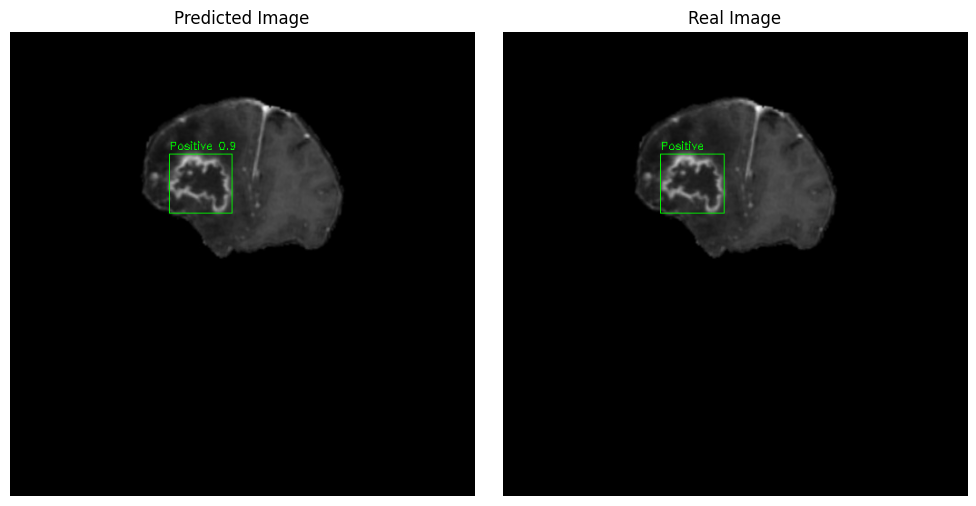

In [ ]:
files = os.listdir(predictions_save_dir)
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]

img_pred = cv2.imread(os.path.join('./coronal_t1wce_2_class/images/test', f'{random_file}.jpg'), 1)
img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)
draw_bbox(predictions_save_dir, random_file, img_pred)

img_real = cv2.imread(os.path.join('./coronal_t1wce_2_class/images/test', f'{random_file}.jpg'), 1)
img_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
draw_bbox('./coronal_t1wce_2_class/labels/test', random_file, img_real)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_pred)
axes[0].set_title('Predicted Image')
axes[0].axis('off')

axes[1].imshow(img_real)
axes[1].set_title('Real Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
text = """
path: ../coronal_t1wce_2_class
train: images/train
val: images/test

# Classes
nc: 2
names: ['negative','positive']
"""
with open("./test.yaml", 'w') as file:
    file.write(text)

In [ ]:
metrics = trained_model.val(data="./test.yaml")

Ultralytics YOLOv8.2.95 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/coronal_t1wce_2_class/labels/test... 78 images, 0 backgrounds, 0 corrupt: 100%|██████████| 78/78 [00:00<00:00, 1733.62it/s]

val: New cache created: /content/coronal_t1wce_2_class/labels/test.cache



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


                   all         78         83          1      0.952       0.99      0.843
              negative         32         34          1      0.952      0.994      0.855
              positive         46         49          1      0.953      0.986      0.831
Speed: 3.5ms preprocess, 25.4ms inference, 0.0ms loss, 5.7ms postprocess per image
Results saved to runs/detect/val3


In [ ]:
test_save_dir = './' + str(metrics.save_dir)

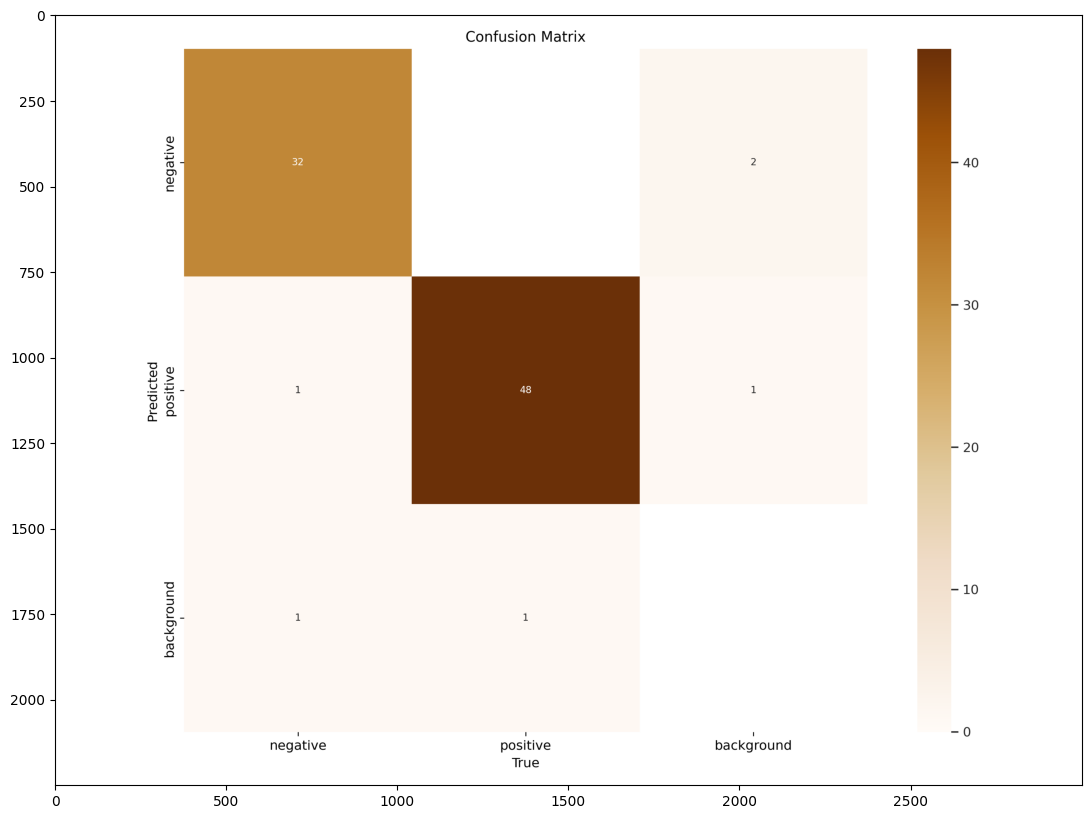

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'confusion_matrix.png'))
plt.imshow(img)
plt.show()

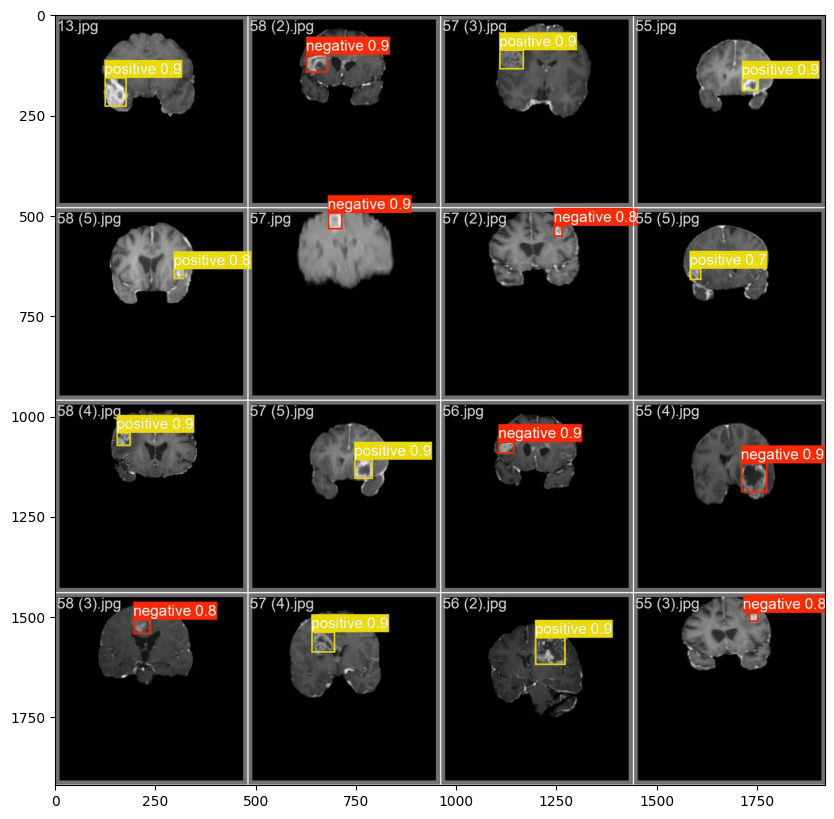

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'val_batch0_pred.jpg'))
plt.imshow(img)
plt.show()

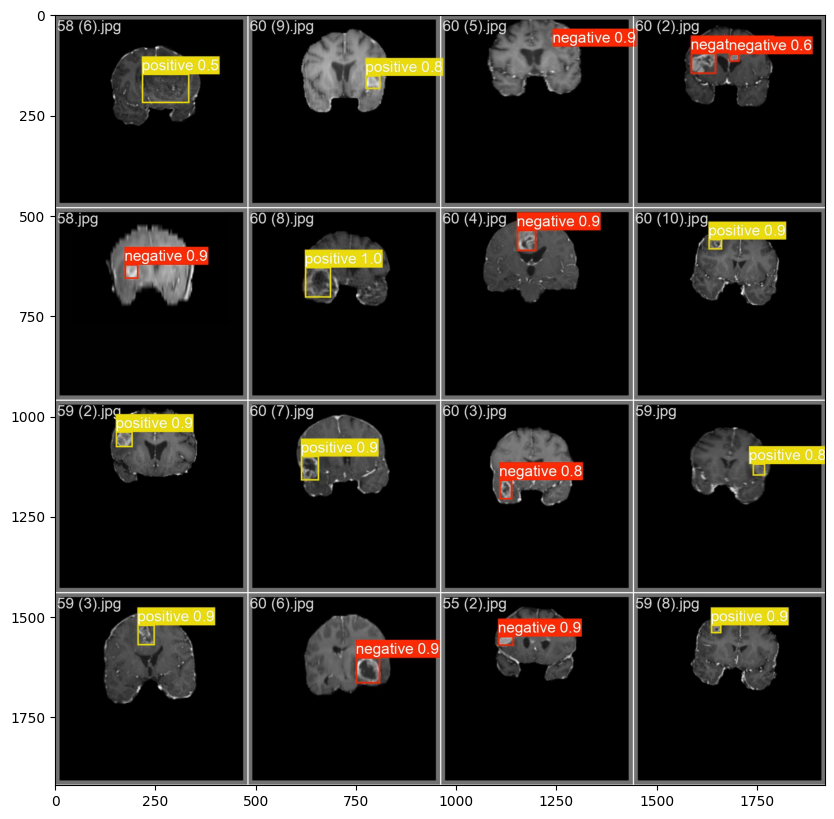

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(test_save_dir, 'val_batch1_pred.jpg'))
plt.imshow(img)
plt.show()

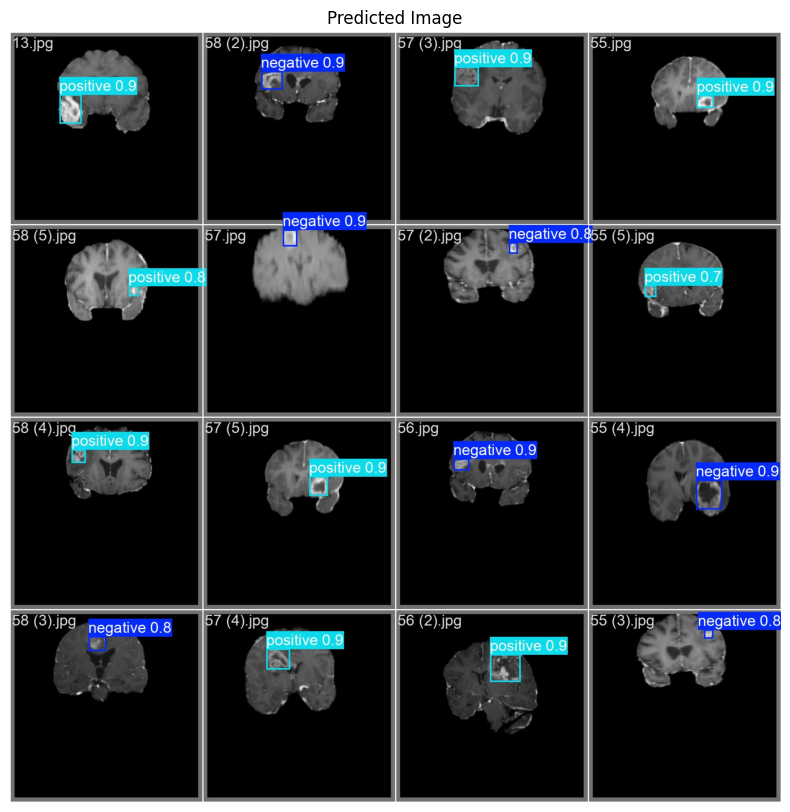

In [ ]:
image_path = os.path.join(test_save_dir, 'val_batch0_pred.jpg')

# Create a figure with a specified size
plt.figure(figsize=(20, 10))

# Read the image using OpenCV
img = cv2.imread(image_path)

# Display the image using matplotlib
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display

# Add a title to the plot (optional)
plt.title('Predicted Image')

# Show the plot
plt.axis('off')  # Hide axis ticks and labels
plt.show()

## [SAM(Segment Anything Model)](https://segment-anything.com/)

In [ ]:
import os
real_path = os.path.join('./coronal_t1wce_2_class/images/test', f'{random_file}.jpg')
print(real_path)

./coronal_t1wce_2_class/images/test/40.jpg


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-g5hsh088
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-g5hsh088
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 526fd066dea338ba2ca08886853bd37ffd6a8aec
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=d32ec83f527e08587789dc443379b009e0c4ab9d2ba3a159fb60570289c3d001
  Stored in directory: /tmp/pip-ephem-wheel-cache-udgy87qw/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything


In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/bin/bash: line 1: {sys.executable}: command not found
--2024-09-15 00:06:13--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.15, 13.226.210.111, 13.226.210.25, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  5.79MB/s    in 4m 42s  

2024-09-15 00:10:55 (8.67 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [ ]:
import cv2
image = cv2.cvtColor(cv2.imread(real_path), cv2.COLOR_BGR2RGB)
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
device = 0
sam.to(device=device)
predictor = SamPredictor(sam)
predictor.set_image(image)

NameError: name 'real_path' is not defined

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [ ]:
model=YOLO('./runs/detect/train/weights/best.pt')
results = model.predict(source=real_path, conf=0.25)
for result in results:
    boxes = result.boxes
bbox = boxes.xyxy.tolist()[0]

In [ ]:
print(bbox)

In [ ]:
input_box = np.array(bbox)
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()